Fit interpretable models to the training set and test on validation sets.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imodels
from rulevetting.api import validation
from rulevetting.projects.csi_pecarn.dataset import Dataset

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_train, df_tune, _ = Dataset().get_data()
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()
feature_names = processed_feats

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

kwargs {'clean_data': {}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}


/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# fit simple models

**decision tree**

100%|██████████| 6/6 [00:00<00:00, 1463.47it/s]


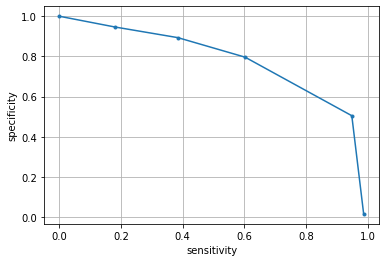

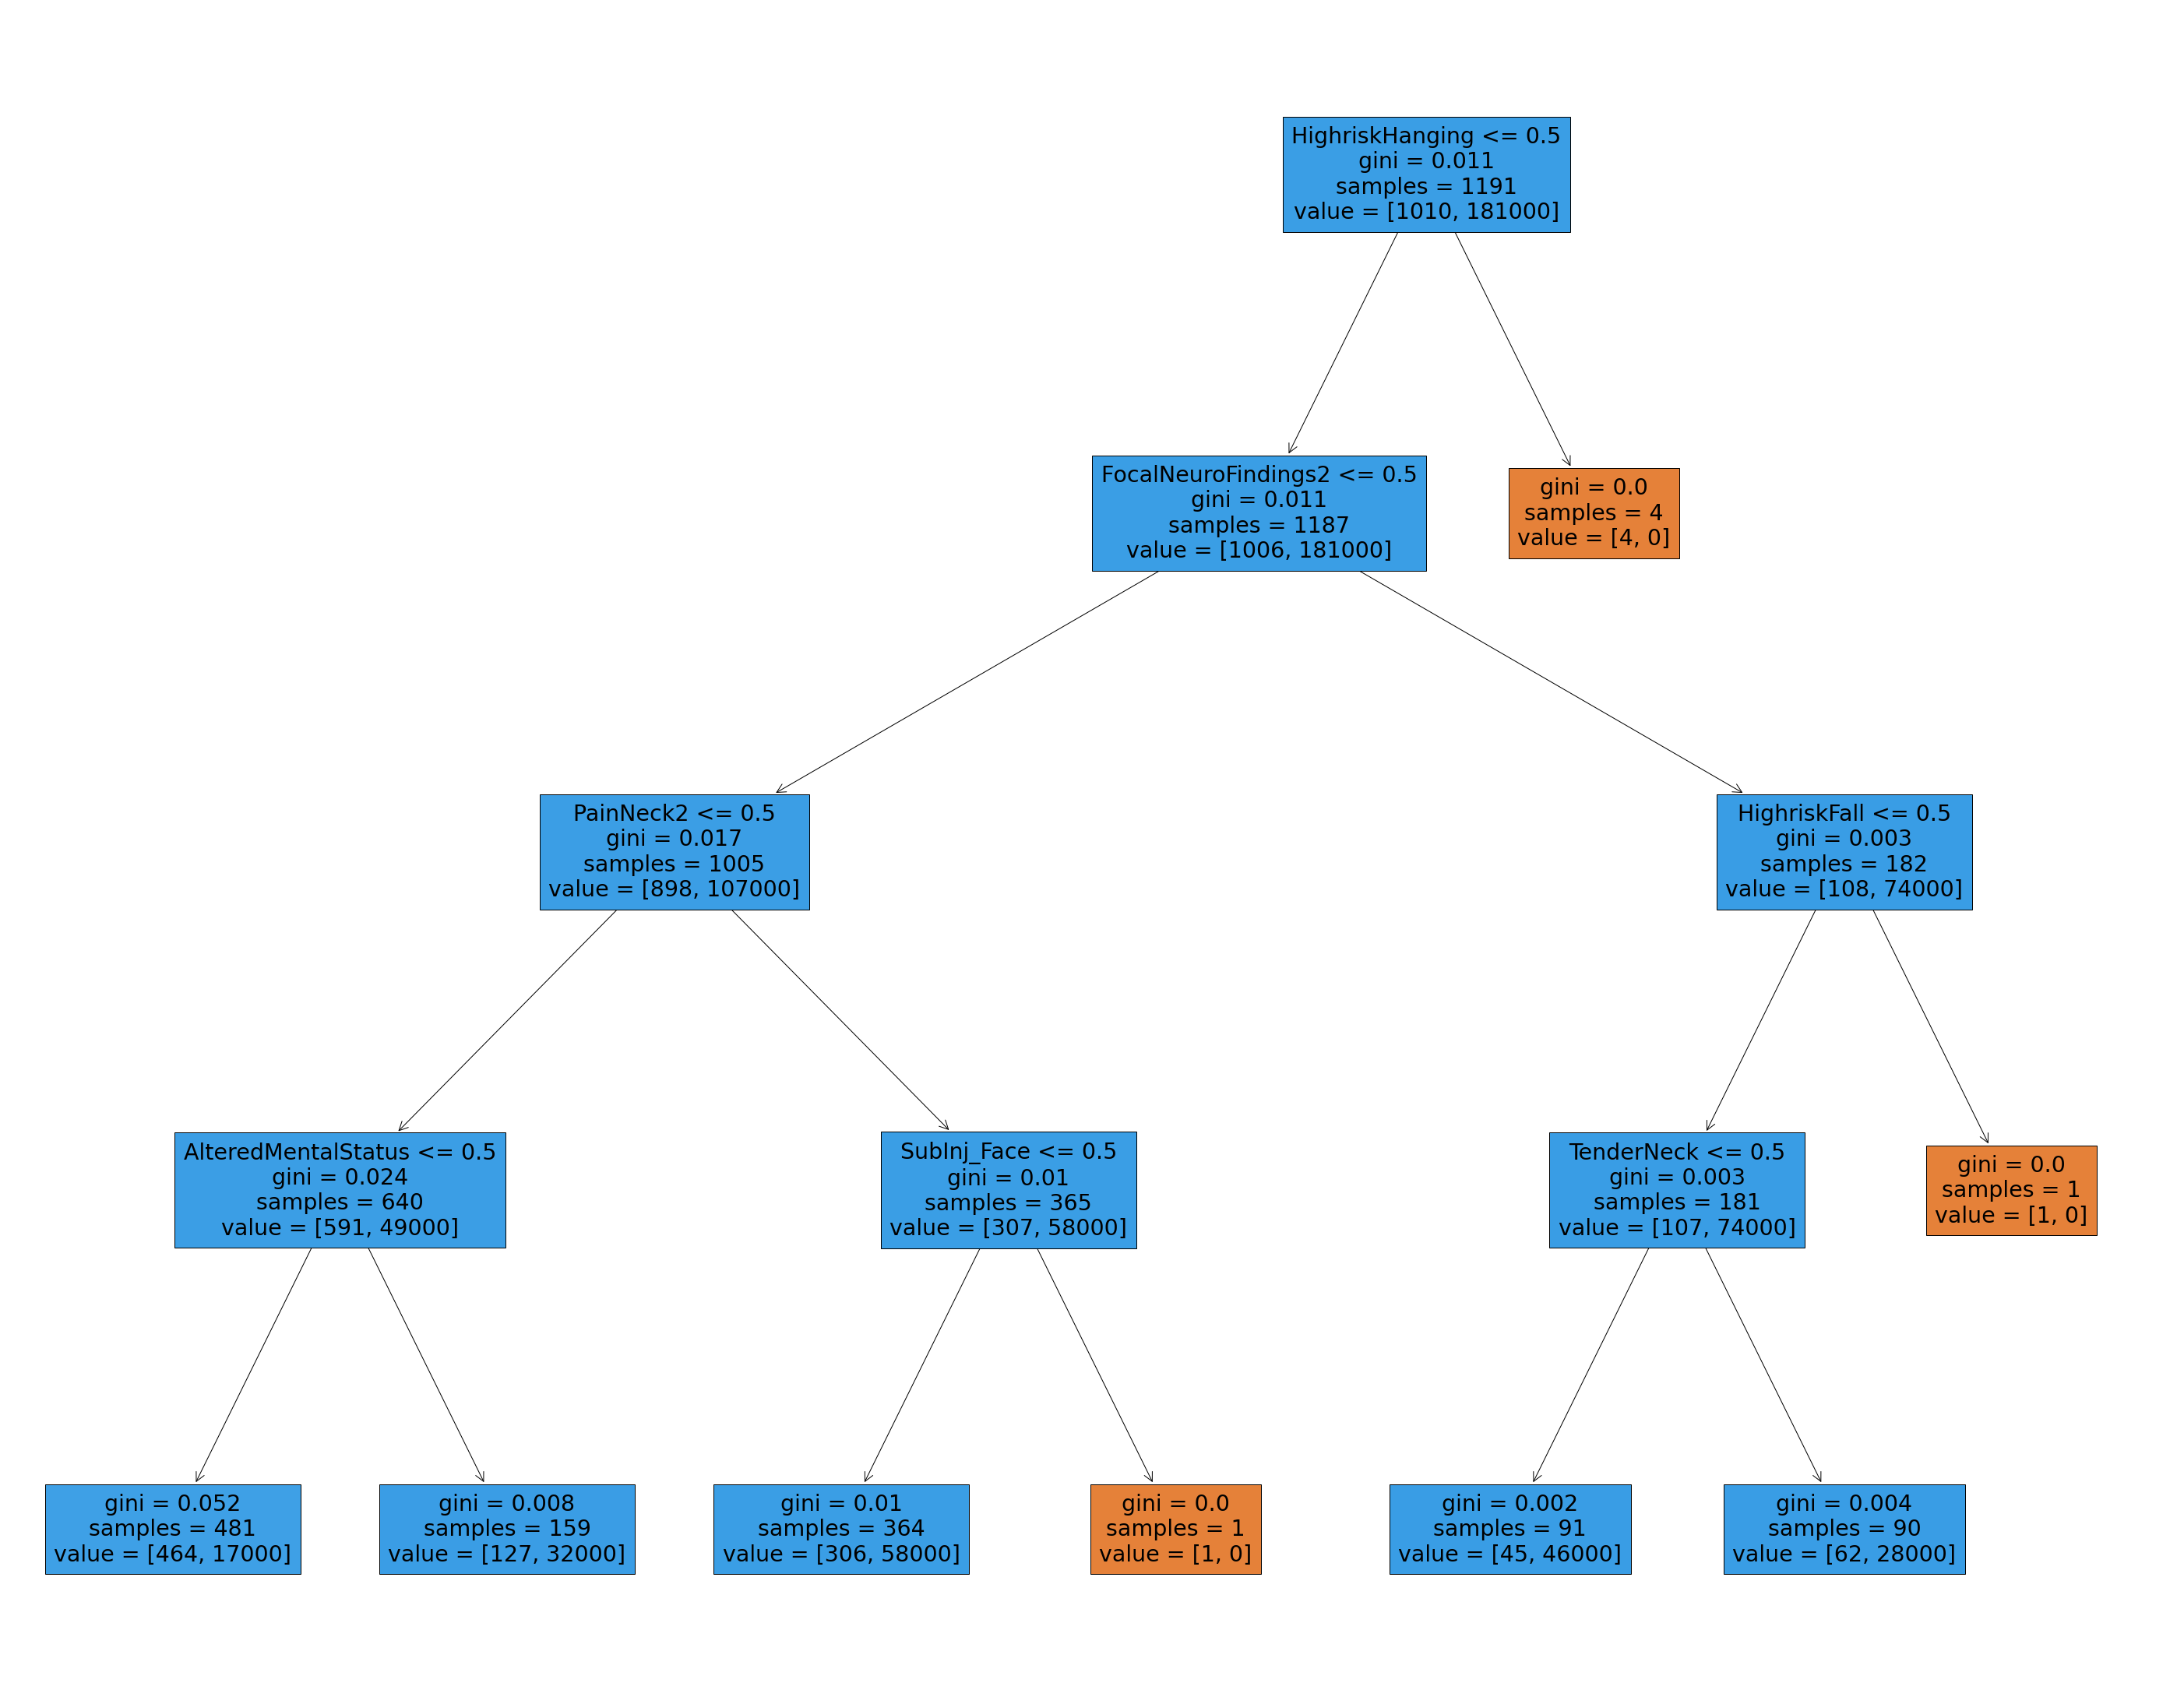

In [11]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

**rulefit**

100%|██████████| 6/6 [00:00<00:00, 1401.29it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

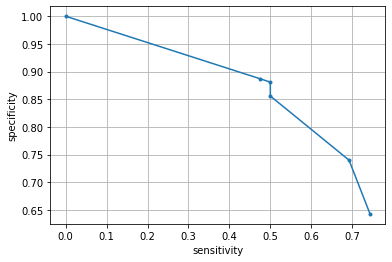

In [12]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [13]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
34,SubInj_TorsoTrunk <= 0.5 and HighriskDiving <= 0.5 and FocalNeuroFindings2 <= 0.5,-0.03
33,HighriskDiving <= 0.5 and HighriskMVC <= 0.5 and FocalNeuroFindings2 <= 0.5,-0.00
32,HighriskDiving <= 0.5 and HighriskMVC <= 0.5 and FocalNeuroFindings2 <= 0.5 and subinj_Head2 <= 0.5,-0.01


**greedy (CART) rule list**

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 9/9 [00:00<00:00, 1751.60it/s]


mean 0.152 (1191 pts)
if FocalNeuroFindings2 >= 1.0 then 0.407 (182 pts)
mean 0.106 (1009 pts)
if feat 13 >= 1.0 then 0.692 (13 pts)
mean 0.098 (996 pts)
if feat 11 >= 1.0 then 0.314 (51 pts)
mean 0.087 (945 pts)
if feat 7 >= 1.0 then 0.263 (57 pts)
mean 0.075 (888 pts)
if feat 17 >= 1.0 then 0.183 (131 pts)
mean 0.057 (757 pts)
if feat 12 >= 1.0 then 0.5 (4 pts)
mean 0.054 (753 pts)
if feat 28 >= 1.0 then 0.111 (108 pts)
mean 0.045 (645 pts)
if feat 24 >= 1.0 then 0.081 (247 pts)
mean 0.023 (398 pts)
if feat 27 >= 1.0 then 0.333 (3 pts)



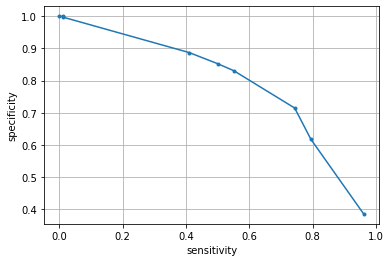

In [14]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

**rf**

In [25]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

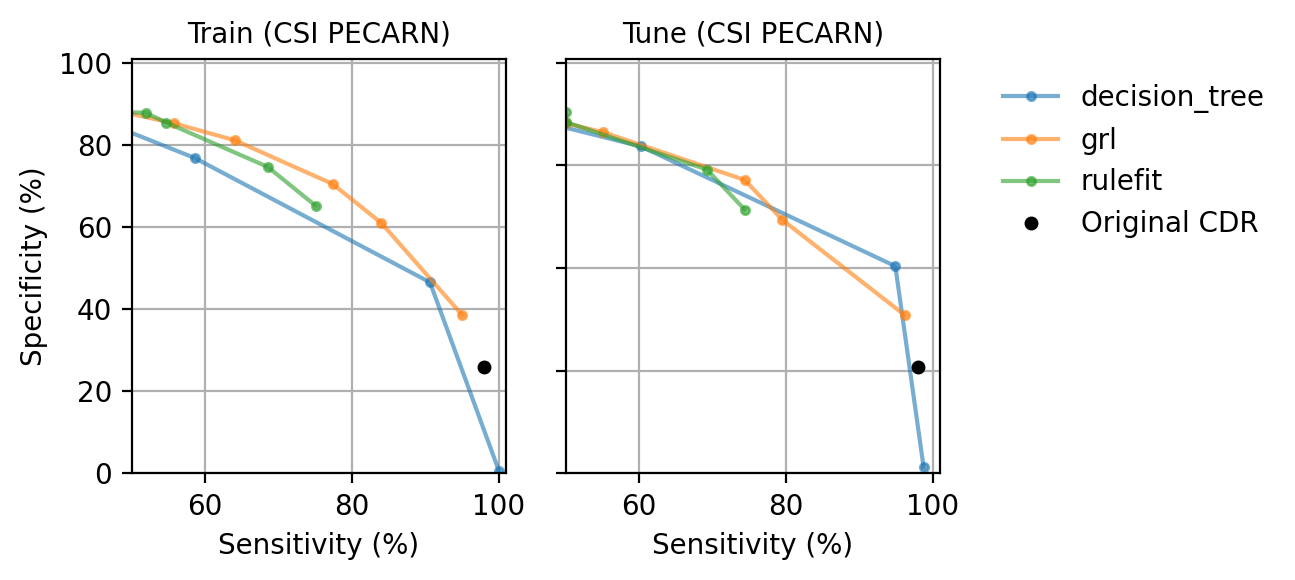

In [17]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    # if suffix == '_test2':
    #     plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    # else:
    plt.plot(98, 26, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (CSI PECARN)', 'Tune (CSI PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
#plt.savefig('figs/metrics_3_splits')
plt.show()

100%|██████████| 6/6 [00:00<00:00, 1135.28it/s]


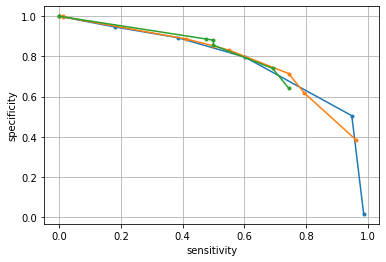

In [20]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [21]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.75
spec,0.01,0.39,0.65
ppv,0.15,0.22,0.28
npv,1.00,0.98,0.94
lr+,1.01,1.55,2.15
lr-,0.00,0.13,0.38
brier_score,0.82,0.11,0.16
f1,0.27,0.35,0.41


In [22]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.95,0.96,0.74
spec,0.50,0.39,0.64
ppv,0.32,0.28,0.34
npv,0.98,0.98,0.91
lr+,1.92,1.56,2.08
lr-,0.10,0.10,0.40
brier_score,0.77,0.13,0.17
f1,0.48,0.43,0.46
